In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv


---

In [3]:
from pprint import pprint
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    accuracy_score,
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    f1 = f1_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall,
        'f1score': f1
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

---

# Carregamento do dataset Kaggle e preparaçao para treino e teste

In [4]:
df_kaggle_train = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv', sep=';')
df_kaggle_test = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv', sep=';')
df_kaggle_test_labels = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv', sep=';')

In [5]:
df_kaggle_train.shape, df_kaggle_test.shape, df_kaggle_test_labels.shape

((526, 263), (52, 262), (52, 2))

In [6]:
all(df_kaggle_test['gs_id'] == df_kaggle_test_labels['gs_id'])

True

---

In [7]:
df_train = df_kaggle_train.sort_values('gs_id', ascending=True).copy()
df_train.set_index('gs_id', inplace=True)

In [8]:
df_test = df_kaggle_test.sort_values('gs_id', ascending=True).copy()
# df_test.loc[:, 'winorlose'] = df_kaggle_test_labels['winorlose']
df_test.set_index('gs_id', inplace=True)

In [9]:
df_test_labels = df_kaggle_test_labels.sort_values('gs_id', ascending=True).copy()
df_test_labels.set_index('gs_id', inplace=True)

df_test_labels = df_test_labels['winorlose'].map({'L': 0, 'W': 1})

In [10]:
df_train.shape, df_test.shape, df_test_labels.shape

((526, 262), (52, 261), (52,))

---

# Pre-processamento

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
encode_target = True
corr_threshold = None
split_data = False
target = 'winorlose'

In [13]:
# bool to numeric
non_numeric_or_object = df_train.select_dtypes(exclude=[np.number, object]).columns
df_train[non_numeric_or_object] = df_train[non_numeric_or_object].astype(int)

non_numeric_or_object = df_test.select_dtypes(exclude=[np.number, object]).columns
df_test[non_numeric_or_object] = df_test[non_numeric_or_object].astype(int)

In [14]:
# cols with values that contain '%' or 'Own' to numeric
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains('Own', na=False)):
            _df[col] = _df[col].str.extract('[Own]?(\d+.\d*)').astype(float)
            continue
        if any(_df[col].str.contains('%', na=False)):
            _df[col] = _df[col].str.extract('(\d+.\d*)[%]').astype(float)
            continue

In [15]:
# remove columns with values that contain ':' or '-'
for _df in [df_train, df_test]:
    for col in _df.select_dtypes(object).columns:
        if any(_df[col].str.contains(':', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue
        if any(_df[col].str.contains('-', na=False)):
            _df.drop(col, axis=1, inplace=True)
            continue

In [16]:
# removing additional columns
cols_to_drop = ['gs_game_day_of_week', 'gs_game_date', 'gs_game_location', 'gs_week_number']
for _df in [df_train, df_test]:
        for _col in cols_to_drop:
            try:
                _df.drop(_col, axis=1, inplace=True)
            except KeyError as e:
                print(e)
                continue

In [17]:
# target encoding
target_encoder = {'L': 0, 'W': 1}
df_train[target] = df_train[target].map(target_encoder)

# col names
cat_cols = df_train.select_dtypes(object).columns.tolist()
num_cols = df_train.select_dtypes(np.number).columns.tolist()

In [18]:
# correlation threshold
if bool(corr_threshold) & encode_target:
    _corr = df_train[num_cols].corrwith(df_train[target])
    correlated_cols = _corr[(_corr >= corr_threshold) & (_corr != 1)].index.tolist()
else:
    correlated_cols = num_cols

In [19]:
# x & y
cols_to_use = cat_cols + correlated_cols
#     if 'gs_id' not in cols_to_use:
#         cols_to_use.append('gs_id')

if target in cols_to_use:
    cols_to_use.remove(target)

In [20]:
x_final = df_train.copy().drop(target, axis=1)
x_final = x_final[cols_to_use]
y_final = df_train[target]

df_test = df_test[cols_to_use]

In [21]:
x_final.shape, y_final.shape, df_test.shape, df_test_labels.shape

((526, 254), (526,), (52, 254), (52,))

---

# Keras

In [22]:
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [23]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [24]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

In [25]:
keras_model = Sequential()
keras_model.add(Dense(128, input_dim = x_final.shape[1], activation='relu'))

keras_model.add(Dense(256, activation='relu'))
keras_model.add(Dense(256, activation='relu'))
keras_model.add(Dense(256, activation='relu'))

keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

2022-09-01 12:30:35.786743: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-09-01 12:30:36.003807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


,model_name,acc,bacc,precision,recall,f1score
0,keras_basic,0.634615,0.604167,1.0,0.208333,0.344828


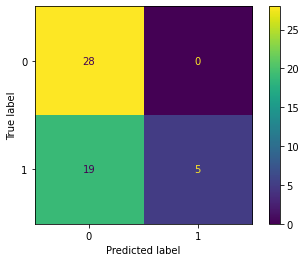

In [26]:
keras_basic = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    keras_model
)

fit_params = {
    'sequential__epochs': 500,
    'sequential__batch_size': 32,
    'sequential__verbose': 0, 
    'sequential__callbacks': [TqdmCallback(verbose=1)]
}

keras_basic.fit(x_final, y_final, **fit_params)
_preds = keras_basic.predict(df_test)
_preds = [0 if p[0] <= 0.5 else 1 for p in _preds]  # convert to 0/1

keras_scores = calculate_scores('keras_basic', df_test_labels, _preds)

# Feature selection

## *Feature importances* from RandomForestClassifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

In [34]:
rfc_tuned_model = RandomForestClassifier(random_state=22)

rfc_tuned = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    rfc_tuned_model
)

rfc_tuned.fit(x_final, y_final)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fded54e28d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fded54e2950>)])),
                ('robustscaler', RobustScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=22))])

In [39]:
importances = [{'feature': feature, 'importance': importance} for feature, importance in zip(x_final.columns.tolist(), rfc_tuned[-1][1].feature_importances_.tolist())]

In [42]:
pd.DataFrame(importances).sort_values('importance', ascending=False)

,feature,importance
88,hts_xpm,0.092241
104,hts_frtd,0.065038
9,hts_points,0.042306
94,hts_kickoff_yds_avg,0.039945
128,hts_points_avg,0.039798
...,...,...
100,hts_rushtd,0.000000
101,hts_rectd,0.000000
103,hts_krtd,0.000000
105,hts_ditd,0.000000
